In [ ]:
# ============================================================================
# SUSTAINABLE SIZING PROJECT - DAY 1: DATA GENERATION
# ============================================================================
# Goal: Generate realistic anthropometric data to expose the "Fit Gap"
# Author: Esra Eslem Savas | Date: 2025
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)


In [ ]:
# ============================================================================
# PART 1: ANTHROPOMETRIC DATA GENERATION
# ============================================================================

def generate_correlated_body_measurements(n=1000, target_market='EU_male'):
    """
    Generate realistic body measurements using multivariate normal distribution.

    Parameters based on ANSUR II (US Army) and Eurostat anthropometric studies:
    - Chest circumference: μ=98cm, σ=8cm
    - Shoulder width: μ=44cm, σ=3cm
    - Torso length: μ=68cm, σ=5cm

    Correlations (empirically observed):
    - chest-shoulder: 0.70 (strongly correlated)
    - chest-torso: 0.60 (moderately correlated)
    - shoulder-torso: 0.50 (moderately correlated)
    """

    # Define mean vector μ
    mean = np.array([98, 44, 68])  # [chest, shoulder, torso]

    # Define covariance matrix Σ
    # Σ[i,j] = ρ[i,j] * σ[i] * σ[j]
    std_devs = np.array([8, 3, 5])

    # Build correlation matrix
    corr_matrix = np.array([
        [1.00, 0.70, 0.60],  # chest correlations
        [0.70, 1.00, 0.50],  # shoulder correlations
        [0.60, 0.50, 1.00]   # torso correlations
    ])

    # Convert correlation to covariance
    cov_matrix = np.outer(std_devs, std_devs) * corr_matrix

    # Generate multivariate normal samples
    measurements = np.random.multivariate_normal(mean, cov_matrix, n)

    # Create DataFrame
    df = pd.DataFrame(measurements, columns=['chest_cm', 'shoulder_cm', 'torso_cm'])
    df['customer_id'] = range(1, n + 1)

    return df

# Generate the dataset
print("Generating 1000 customer measurements...")
df = generate_correlated_body_measurements(n=1000)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst 5 customers:")
print(df.head())



Generating 1000 customer measurements...

Dataset shape: (1000, 4)

First 5 customers:
    chest_cm  shoulder_cm   torso_cm  customer_id
0  94.222743    41.576614  66.706092            1
1  85.589533    41.015101  63.098317            2
2  86.572004    41.521403  59.505899            3
3  92.801116    43.634606  67.474143            4
4  92.289151    46.574214  73.272847            5


In [ ]:
# ============================================================================
# PART 2: STANDARD SIZING LOGIC (THE PROBLEM)
# ============================================================================

def assign_standard_size(chest_cm):
    """
    Traditional S/M/L sizing based on chest circumference.
    Industry standard breakpoints:
    - S: < 92cm
    - M: 92-104cm
    - L: > 104cm
    """
    if chest_cm < 92:
        return 'S'
    elif chest_cm < 104:
        return 'M'
    else:
        return 'L'

def calculate_fit_error(chest_cm, assigned_size):
    """
    Calculate how far customer is from "ideal center" of their size.
    Size centers: S=88cm, M=98cm, L=108cm
    """
    size_centers = {'S': 88, 'M': 98, 'L': 108}
    return abs(chest_cm - size_centers[assigned_size])

# Apply standard sizing
df['standard_size'] = df['chest_cm'].apply(assign_standard_size)
df['fit_error_cm'] = df.apply(lambda row: calculate_fit_error(row['chest_cm'], row['standard_size']), axis=1)

# Calculate poor fit rate (fit error > 6cm)
df['poor_fit'] = df['fit_error_cm'] > 6

print("\n" + "="*60)
print("STANDARD SIZING ANALYSIS (S/M/L)")
print("="*60)
print(f"\nSize Distribution:")
print(df['standard_size'].value_counts().sort_index())
print(f"\n% Poor Fits (>6cm error): {df['poor_fit'].mean()*100:.1f}%")
print(f"Number of Poor Fits: {df['poor_fit'].sum()}")
print(f"\nMean Fit Error: {df['fit_error_cm'].mean():.2f} cm")
print(f"Median Fit Error: {df['fit_error_cm'].median():.2f} cm")
print(f"Max Fit Error: {df['fit_error_cm'].max():.2f} cm")



STANDARD SIZING ANALYSIS (S/M/L)

Size Distribution:
standard_size
L    199
M    574
S    227
Name: count, dtype: int64

% Poor Fits (>6cm error): 4.1%
Number of Poor Fits: 41

Mean Fit Error: 2.94 cm
Median Fit Error: 2.70 cm
Max Fit Error: 23.10 cm


In [ ]:
# ============================================================================
# PART 3: STATISTICAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("MEASUREMENT STATISTICS")
print("="*60)
print("\nDescriptive Statistics:")
print(df[['chest_cm', 'shoulder_cm', 'torso_cm']].describe())

print("\nCorrelation Matrix:")
print(df[['chest_cm', 'shoulder_cm', 'torso_cm']].corr())



MEASUREMENT STATISTICS

Descriptive Statistics:
          chest_cm  shoulder_cm     torso_cm
count  1000.000000  1000.000000  1000.000000
mean     97.583545    43.782400    67.822089
std       7.858126     2.896275     4.819958
min      64.903774    31.432732    50.265000
25%      92.537019    41.873457    64.563010
50%      97.502792    43.754281    67.966393
75%     102.519936    45.716413    71.106800
max     123.833723    52.978872    83.324677

Correlation Matrix:
             chest_cm  shoulder_cm  torso_cm
chest_cm     1.000000     0.686897  0.561547
shoulder_cm  0.686897     1.000000  0.485846
torso_cm     0.561547     0.485846  1.000000


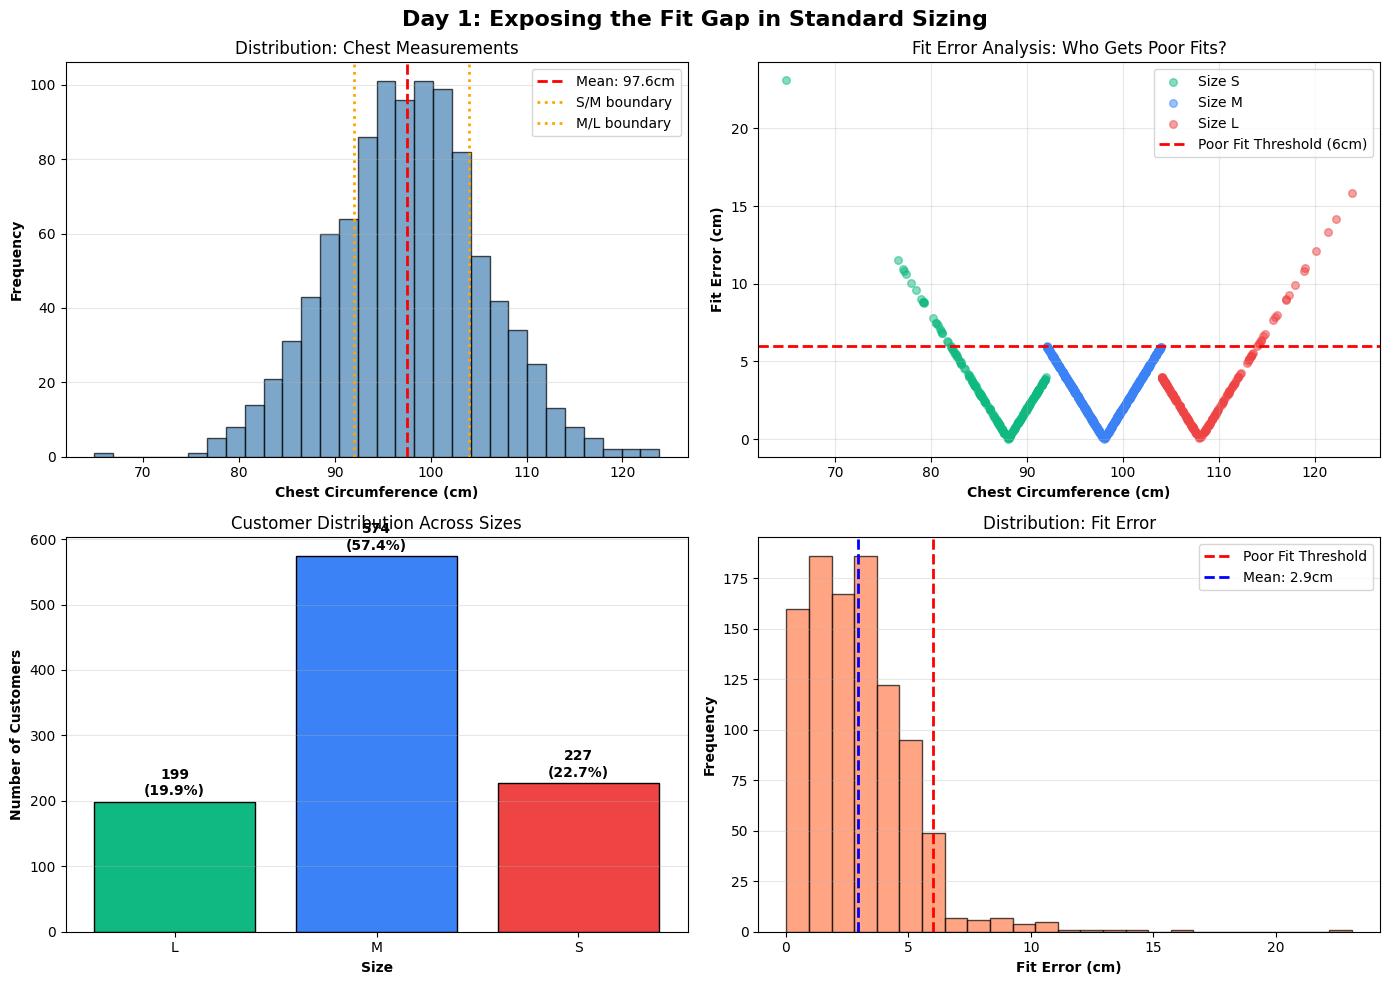

In [ ]:
# ============================================================================
# PART 4: VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Day 1: Exposing the Fit Gap in Standard Sizing', fontsize=16, fontweight='bold')

# Plot 1: Chest circumference distribution
axes[0, 0].hist(df['chest_cm'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['chest_cm'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["chest_cm"].mean():.1f}cm')
axes[0, 0].axvline(92, color='orange', linestyle=':', linewidth=2, label='S/M boundary')
axes[0, 0].axvline(104, color='orange', linestyle=':', linewidth=2, label='M/L boundary')
axes[0, 0].set_xlabel('Chest Circumference (cm)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Distribution: Chest Measurements')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Fit error by size
size_colors = {'S': '#10b981', 'M': '#3b82f6', 'L': '#ef4444'}
for size in ['S', 'M', 'L']:
    size_data = df[df['standard_size'] == size]
    axes[0, 1].scatter(size_data['chest_cm'], size_data['fit_error_cm'],
                      alpha=0.5, s=30, color=size_colors[size], label=f'Size {size}')

axes[0, 1].axhline(6, color='red', linestyle='--', linewidth=2, label='Poor Fit Threshold (6cm)')
axes[0, 1].set_xlabel('Chest Circumference (cm)', fontweight='bold')
axes[0, 1].set_ylabel('Fit Error (cm)', fontweight='bold')
axes[0, 1].set_title('Fit Error Analysis: Who Gets Poor Fits?')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Size distribution
size_counts = df['standard_size'].value_counts().sort_index()
axes[1, 0].bar(size_counts.index, size_counts.values, color=['#10b981', '#3b82f6', '#ef4444'], edgecolor='black')
axes[1, 0].set_xlabel('Size', fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers', fontweight='bold')
axes[1, 0].set_title('Customer Distribution Across Sizes')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (size, count) in enumerate(size_counts.items()):
    axes[1, 0].text(i, count + 10, f'{count}\n({count/len(df)*100:.1f}%)',
                   ha='center', fontweight='bold')

# Plot 4: Fit error distribution
axes[1, 1].hist(df['fit_error_cm'], bins=25, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(6, color='red', linestyle='--', linewidth=2, label='Poor Fit Threshold')
axes[1, 1].axvline(df['fit_error_cm'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {df["fit_error_cm"].mean():.1f}cm')
axes[1, 1].set_xlabel('Fit Error (cm)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Distribution: Fit Error')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('day1_fit_gap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# PART 5: BUSINESS IMPACT CALCULATION
# ============================================================================

print("\n" + "="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

# Assumptions
avg_item_price = 50  # EUR
return_cost = 12     # EUR (logistics, processing)
co2_per_return = 20  # kg CO2
poor_fit_return_rate = 0.70  # 70% of poor fits result in returns

poor_fits = df['poor_fit'].sum()
expected_returns = int(poor_fits * poor_fit_return_rate)

revenue_loss = expected_returns * avg_item_price
operational_cost = expected_returns * return_cost
total_cost = revenue_loss + operational_cost
co2_emissions = expected_returns * co2_per_return

print(f"\nFor 1,000 customers:")
print(f"  Poor Fits: {poor_fits} ({poor_fits/10:.1f}%)")
print(f"  Expected Returns: {expected_returns}")
print(f"\nFinancial Impact:")
print(f"  Lost Revenue: €{revenue_loss:,}")
print(f"  Return Processing: €{operational_cost:,}")
print(f"  Total Cost: €{total_cost:,}")
print(f"\nEnvironmental Impact:")
print(f"  CO₂ Emissions: {co2_emissions:,} kg")
print(f"\n💡 If we reduce poor fits by 50%, we save €{int(total_cost*0.5):,} and {int(co2_emissions*0.5):,}kg CO₂")



BUSINESS IMPACT ANALYSIS

For 1,000 customers:
  Poor Fits: 41 (4.1%)
  Expected Returns: 28

Financial Impact:
  Lost Revenue: €1,400
  Return Processing: €336
  Total Cost: €1,736

Environmental Impact:
  CO₂ Emissions: 560 kg

💡 If we reduce poor fits by 50%, we save €868 and 280kg CO₂


In [ ]:
# ============================================================================
# PART 6: EXPORT DATA FOR NEXT NOTEBOOKS
# ============================================================================

# Save to CSV
df.to_csv('anthropometric_data.csv', index=False)
print(f"\n✅ Data exported to 'anthropometric_data.csv'")

# Save summary statistics
summary_stats = {
    'total_customers': len(df),
    'poor_fit_rate': df['poor_fit'].mean(),
    'mean_fit_error': df['fit_error_cm'].mean(),
    'size_distribution': df['standard_size'].value_counts().to_dict(),
    'correlation_chest_shoulder': df['chest_cm'].corr(df['shoulder_cm']),
    'correlation_chest_torso': df['chest_cm'].corr(df['torso_cm'])
}

print("\n" + "="*60)
print("DAY 1 COMPLETE ✅")
print("="*60)
print("\nKey Findings:")
print(f"1. Standard sizing produces {df['poor_fit'].sum()} poor fits ({df['poor_fit'].mean()*100:.1f}%)")
print(f"2. Chest-shoulder correlation: {summary_stats['correlation_chest_shoulder']:.2f} (strong!)")
print(f"3. Business cost: €{total_cost:,} in returns")
print("\nNext Step: Run 02_eda_correlation.ipynb to find clustering opportunities")


✅ Data exported to 'anthropometric_data.csv'

DAY 1 COMPLETE ✅

Key Findings:
1. Standard sizing produces 41 poor fits (4.1%)
2. Chest-shoulder correlation: 0.69 (strong!)
3. Business cost: €1,736 in returns

Next Step: Run 02_eda_correlation.ipynb to find clustering opportunities


In [ ]:
from google.colab import files
files.download('anthropometric_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>